# Acrobot

- [openAI gym::Acrobot v1](https://gym.openai.com/envs/Acrobot-v1/)
- 以下の説明は[vmayoral:basic_reinforcement_learning/tutorial4/README.md](https://github.com/vmayoral/basic_reinforcement_learning/blob/master/tutorial4/README.md)を参考資料として作成したものです。


**Acrobotは適当な報酬関数を考える必要あり!**

## Random action

KeyboardInterrupt: 

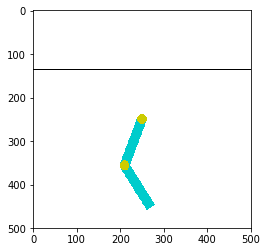

In [1]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('Acrobot-v1')

for n_episode in range (3):
    observation = env.reset()
    for t in range(100):
        plt.imshow(env.render(mode='rgb_array'))
        display.clear_output(wait=True)
        display.display(plt.gcf())

        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode {} finished after {} timesteps".format(n_episode+1,t+1))
            break

## 概要

[OpenAI Gym Acrobot-v1]https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py)を参照

## action, state空間の確認

In [2]:
import gym
env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
print(env.observation_space)

Box(6,)


In [4]:
print(env.observation_space.low)

[ -1.        -1.        -1.        -1.       -12.566371 -28.274334]


In [5]:
print(env.action_space)

Discrete(3)


In [6]:
print(env.observation_space.high)

[ 1.        1.        1.        1.       12.566371 28.274334]


In [7]:
obs=env.reset()
print(obs)

[ 0.99717562  0.07510518  0.99684654 -0.07935347 -0.05432302  0.06450456]


In [8]:
cos1, sin1, cos2, sin2, dot1, dot2=obs  # obsの各要素を， 別々の変数に代入する
print(cos1, sin1, cos2, sin2,dot1,dot2)

0.9971756175739109 0.07510517769161638 0.9968465409703405 -0.07935347349339623 -0.05432302168460706 0.0645045584999818


## 問題点
- 問題点: 状態空間が連続値をとる。
- 対策: 連続値のまま扱う方法もあるが，今回は，状態空間を離散値に分割する。いくつの状態空間に分割するべきかは考慮すべき点。

**[質問]** 状態空間を多数の離散値に分割することのメリットとデメリットを説明しなさい。

In [108]:
# 状態の各要素をそれぞれ離散化
import numpy as np

n_bins=10 # n_bins-2個の閉区間 + 両端の2個
bins = np.linspace(start=-2.0, stop=2.0, num=n_bins-1) # [start,stop]をnbins個の点で区切る(閉区間はnbins-1個)

def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

[numpy.linspace(start,stop,num)](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html)
    - `start`, `stop`: スカラー
    - `num`: 生成するサンプル数
[numpy.digitize(x,bins)](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html)
    - `x`: 1次元配列
    - `bins`: binsの配列
    - 返り値: `bins[i-1] <= x < bins[i]`を満たすi (i=1,...,len(bins)-1)を返す。binsの範囲を超えたら，その値に応じて0か最大値(`len(bins)`)のベクトル(ndarray)を返す

- **[質問]** 上記のように状態の各要素をそれぞれ10個の離散値にした場合，とりうる状態数は全部でいくつになりますか?
- **[質問]** 1エピソードが平均10ステップとすると，全ての状態に対する学習を1回づつ行うには最低何回のエピソードが必要ですか?

In [119]:
bins=np.linspace(start=-2.0, stop=2.0, num=9)
print(bins)
print(len(bins))
print(np.digitize(x=[-1.9],bins=bins))
print(np.digitize(x=[-2.1],bins=bins)[0])
print(np.digitize(x=[1.9],bins=bins)[0])
print(np.digitize(x=[2.1],bins=bins)[0])

[-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2. ]
9
[1]
0
8
9


## Q学習

In [10]:
class QLearn:
    def __init__(self, actions, epsilon, alpha, gamma):
        self.q = {}
        self.epsilon = epsilon  # exploration constant
        self.alpha = alpha      # discount constant
        self.gamma = gamma      # discount factor
        self.actions = actions

    def getQ(self, state, action):
        return self.q.get((state, action), 0.0)

    def learnQ(self, state, action, reward, maxqnew):
        '''
        Q-learning:
            Q(s, a) += alpha * (reward + max(Q(s')) - Q(s,a))            
        '''
        oldq = self.q.get((state, action), None)
        if oldq is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = oldq + self.alpha * (reward + self.gamma*maxqnew - oldq)

    def chooseAction(self, state, return_q=False):
        q = [self.getQ(state, a) for a in self.actions]
        maxQ = max(q)

        if random.random() < self.epsilon:
            minQ = min(q); mag = max(abs(minQ), abs(maxQ))
            # add random values to all the actions, recalculate maxQ
            q = [q[i] + random.random() * mag - .5 * mag for i in range(len(self.actions))] 
            maxQ = max(q)

        count = q.count(maxQ)
        # 最大値をとるactionが複数あるときは，random選択
        if count > 1:
            best = [i for i in range(len(self.actions)) if q[i] == maxQ]
            i = random.choice(best)
        else:
            i = q.index(maxQ)

        action = self.actions[i]        
        if return_q: # Q値も返す場合
            return action, q
        return action

    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.getQ(state2, a) for a in self.actions])
        self.learnQ(state1, action1, reward, maxqnew)

**[問題]** acrobotを学習プログラムを作りなさい。状態の離散化は以下で行える。ただし，状態分割を行う区間は各自検討すること。
- 報酬の設定方法次第で学習効率はいろいろ変わる。例えば，エピソード終了時(タスク失敗時)の報酬は-20とすると，どのように学習速度は変わるだろうか。
- さらに，学習を早くするにはどのような工夫をできるだろうか。報酬設定だけではなく，いろいろな可能性を考えて検証しなさい。

In [17]:
import numpy as np
import random
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym import wrappers

env = gym.make('Acrobot-v1')
env = wrappers.Monitor(env, './video-acrobot') # save animations

N_EPSD=1000
DISP_EPSD=1000 # アニメーション表示は非常に時間がかかる!
T_MAX=100
N_BINS=10
env.spec.timestep_limit=T_MAX-1

history=np.zeros(N_EPSD)

ang_bins = np.linspace(start=-0.8, stop=0.8, num=N_BINS-1)
dot_bins = np.linspace(start=-10, stop=10, num=N_BINS-1)

def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]


rl=QLearn(actions=list(range(env.action_space.n)),
                        alpha=0.5, gamma=0.9, epsilon=0.1)

for i_episode in range (N_EPSD):
    obs = env.reset()
    cos1, sin1, cos2, sin2, dot1, dot2 = obs
    state = build_state([to_bin(cos1, ang_bins),
                         to_bin(sin1, ang_bins),
                         to_bin(cos2, ang_bins),
                         to_bin(sin2, ang_bins),
                         to_bin(dot1, dot_bins),
                         to_bin(dot2, dot_bins)])    
    
    for t in range(T_MAX):
        if i_episode % DISP_EPSD == 0:
            print("Episode={}, Time={}".format(i_episode+1,t+1))
            plt.imshow(env.render(mode='rgb_array'))
            display.clear_output(wait=True)
            display.display(plt.gcf())

        action = rl.chooseAction(state) # act randomly

        obs_new, reward, terminal, info = env.step(action)
        cos1, sin1, cos2, sin2, dot1, dot2 = obs_new
        state_new =  build_state([to_bin(cos1, ang_bins),
                         to_bin(sin1, ang_bins),
                         to_bin(cos2, ang_bins),
                         to_bin(sin2, ang_bins),
                         to_bin(dot1, dot_bins),
                         to_bin(dot2, dot_bins)])       

        rl.learn(state, action, reward, state_new)
        
        if terminal:
            if i_episode % DISP_EPSD == 0:
                plt.imshow(env.render(mode='rgb_array'))
                display.clear_output(wait=True)
                display.display(plt.gcf())

            reward=-20
            rl.learn(state, action, reward, state_new)

            print("Episode {} finished after {} timesteps".format(i_episode+1,t+1))
            history[i_episode]=t+1
            break

        state = state_new

DeprecatedEnv: Env Acrobot-v0 not found (valid versions include ['Acrobot-v1'])

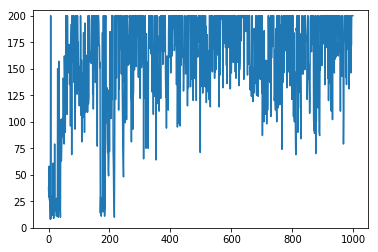

In [129]:
plt.ylim(0,history.max()+5)
plt.plot(history)